<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/02_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [1]:
# 코랩을 사용하지 않으면 이 셀의 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=2)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 566, done.
remote: Counting objects: 100% (300/300), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 566 (delta 181), reused 184 (delta 107), pack-reused 266
Receiving objects: 100% (566/566), 48.97 MiB | 9.28 MiB/s, done.
Resolving deltas: 100% (280/280), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.26.1
Using datasets v2.10.1
Using accelerate v0.16.0
Using sentencepiece v0.1.97
Using umap v0.5.3


In [2]:
!pwd

/content/nlp-with-transformers


# 텍스트 분류

<img alt="Tesla Tweet" width="500" caption="Analyzing Twitter content can yield useful feedback from customers (courtesy of Aditya Veluri)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_tweet.png?raw=1" id="tesla-tweet"/>

<img alt="Hugging Face Pipeline" caption="A typical pipeline for training transformer models with the image:images/logo.png[hf,13,13] Datasets, image:images/logo.png[hf,13,13] Tokenizers, and image:images/logo.png[hf,13,13] Transformers libraries" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_hf-libraries.png?raw=1" id="hf-libraries"/>

## 데이터셋

### 허깅 페이스 데이터셋 처음 사용하기

In [3]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있습니다.")
print(f"처음 10개 데이터셋: {all_datasets[:10]}")

현재 허브에는 23761개의 데이터셋이 있습니다.
처음 10개 데이터셋: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa',
'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue',
'ajgt_twitter_ar', 'allegro_reviews']


각 데이터셋은 고유한 이름이 있습니다. `load_dataset()` 함수로 `emotion` 데이터셋을 로드해보죠.

In [4]:
from datasets import load_dataset

emotions = load_dataset("emotion")
emotions

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions['train']
print(train_ds)
print(len(train_ds))

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})
16000


In [6]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
# 한 개의 행이 하나의 딕셔너리로 표현되고, 여기서 key는 열 이름에 해당한다.
train_ds.column_names

['text', 'label']



*   허깅페이스 데이터셋은 **아파치 애로우(Apache Arrow)를 기반**으로 한다.
*   아파치 애로우는 기본적인 파이썬보다 더욱 **메모리 효율적인 열기반 포맷(typed columnar format)을 사용**한다. 
*   현재 **데이터 타입은 Dataset 객체의 features 속성에 표시**된다.
*   text 열의 데이터 타입 : string
*   label 열의 데이터 타입 : class 이름과 정수 매핑에 대한 정보가 담긴 특별한  ClassLabel 객체



In [8]:
# 현재 데이터 타입은 Dataset 객체의 features 속성에 표시된다.
# text 열의 데이터 타입 : string
# label 열의 데이터 타입 : class 이름과 정수 매핑에 대한 정보가 담긴 특별한  ClassLabel 객체
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness',
'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [9]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


In [10]:
# 위에서 load한 'emtion' dataset과 다르게 label_text column이 추가되어 있다.
# emotion 데이터셋이 다운로드되지 않으면 SetFit/emotion을 사용합니다.

# emotions = load_dataset("SetFit/emotion")

In [11]:
# emotions['train'][0]

In [12]:
# SetFit/emotion 데이터셋의 경우 수동으로 ClassLabel 객체를 만들어 label에 할당합니다.
# from datasets import ClassLabel

# emotions['train'].features['label'] = ClassLabel(
#     num_classes=6, 
#     names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

# print(emotions)
# train_ds = emotions["train"]
# print(train_ds)
# print(len(train_ds))
# print(train_ds[0])
# print(train_ds.column_names)
# print(train_ds.features)
# print(train_ds[:5])
# print(train_ds["text"][:5])

### 사이드바: 허브에 필요한 데이터셋이 없다면 어떻게 하나요?


*   보통의 경우 허깅페이스 허브를 사용해 데이터 셋을 다운로드하기도 하지만, 많은 경우 local 컴퓨터나 회사 원격 서버에 저장된 데이터를 사용하여 작업한다. 
*   이러한 경우에 대비해 허깅페이스 데이터셋은 로컬 데이터셋이나 원격 데이터셋에 사용 가능한 로딩 스크립트를 제공한다.
*   데이터 포맷에따라 load_dataset()함수를 이용하여 data load 한 뒤 형식에 맞게 변경



***`emotion` 데이터셋의 드롭박스 경로가 현재 유효하지 않습니다. 따라서 이 사이드바의 코드는 실행되지 않습니다.***

In [13]:
# dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
# !wget {dataset_url}

In [14]:
# !head -n 1 train.txt

In [15]:
# emotions_local = load_dataset("csv", data_files="train.txt", sep=";", 
#                               names=["text", "label"])

In [16]:
# dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt?dl=1"
# emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";", 
#                                names=["text", "label"])

### 사이드바 끝

### 데이터셋에서 데이터프레임으로
*   허깅페이스 dataset에서 제공하는 **set_format()** 메소드를 이용하여 Dataset의 출력 포맷을 변경

In [17]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [18]:
# 파이썬에서 모든 객체는 __class__라는 특별한 속성을 가지는데, 여기에는 해당 객체의 데이터 타입이 저장이 되어 있다.
emotions["train"].features['label'].__class__

datasets.features.features.ClassLabel

In [19]:
# 위의 경우 label이 정수로 출력되기 때문에 features 속성으로 label 열을 선택하고, 
# int2str() method로 레이블 이름에 해당하는 새로운 열을 Dataframe에 추가
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### 클래스 분포 살펴 보기

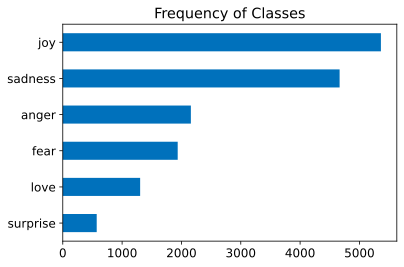

In [20]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [21]:
df["label_name"].value_counts(ascending=True)

surprise     572
love        1304
fear        1937
anger       2159
sadness     4666
joy         5362
Name: label_name, dtype: int64

### 트윗 길이 확인
*   transformer model은 **최대 문맥 크기(maximum context size)**라는 최대 입력 시퀀스 길이가 존재한다. 
*   본 label에따라서 context size 확인
*   DistilBERT의 최대 문맥 크기 : 512토큰으로 문단 몇 개 정도

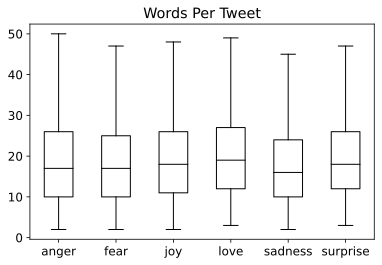

In [22]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [23]:
emotions.reset_format()
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## 텍스트에서 토큰으로

### 문자 토큰

In [24]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)
print(len(tokenized_text))

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']
38


In [25]:
# 각 문자를 정수로 수치화하는 과정
# 각각의 토큰(이 경우에서는 문자)을 고유한 정수로 인코딩 시켜준다.
# token2idx : vocabulary에 있는 각 문자를 고유한 정수로 바꾸는 매핑 딕셔너리 

token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9,
'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18,
'z': 19}


In [26]:
# 위애서 정수로 인코딩 된 각각의 토큰을 이용해서 토큰화된 텍스트를 정수 리스트로 변환시켜준다.
 
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [27]:
# 앞의 과정을 통해서 각 토큰이 숫자 식별자로 매핑 완료
# 마지막 단계로 input_ids를 one-hot vector의 2D tensor로 바꾸어준다. 

categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [28]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [29]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
print(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
print(one_hot_encodings.shape)
print(one_hot_encodings)

tensor([ 5, 14, 12,  8, 13, 11, 19, 11, 13, 10,  0, 17,  8, 18, 17,  0, 11, 16,
         0,  6,  0,  7, 14, 15,  8,  0, 17,  6, 16, 12,  0, 14,  9,  0,  3,  2,
         4,  1])
torch.Size([38, 20])
tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0,

In [30]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [31]:
F.one_hot(torch.tensor([0,2]), num_classes=11).shape

torch.Size([2, 11])

In [32]:
import tensorflow as tf

tf.one_hot([0,1, 2], 1)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[1.],
       [0.],
       [0.]], dtype=float32)>

### 단어 토큰화

In [33]:
# 문제점 존재 : 구두점이 고려되지 않아서 "NLP."이 하나의 토큰으로 처리된다.
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


### 부분단어 토큰화
 *   부분단어 토큰화는 기본적으로 문자 토큰화와 단어 토큰화의 장점을 결합한 방법이다. 
 *   BERT와 DistilBERT에서 사용되는 토크나이저 : WordPiece
 *   허깅페이서의 transformer는 사전 훈련된 모델에 연관된 토크나이저를 load하는 **AutoTokenizer** class를 제공한다.
 *   **AutoTokenizer** class : 체크포인트 이름을 사용해 **모델의 설정, 사전 훈련된 가중치, 어휘 가중치, 어휘 사전을 자동으로 추출하는 자동 클래스**이다.
 *   **from_pretrained()** method를 허브의 모델 ID나 local 파일 경로와 함께 호출

In [34]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [35]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [36]:
# convert_ids_to_tokens()를 이용하여 input_ids를 다시 토큰으로 변환 
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '.', '[SEP]']


In [37]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [38]:
tokenizer.vocab_size

30522

In [39]:
tokenizer.model_max_length

512

In [40]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### 전체 데이터셋 토큰화하기

In [41]:
# sample을 토큰화할 처리 함수 
# padding = True로 지정하면 배치에 있는 가장 긴 sample 크기에 맞춰서 sample들을 샘플을 0으로 padding
# truncation=True로 설정하면 모델의 최대 문맥 크기에 맞춰 샘플을 잘라낸다. 

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [42]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


In [43]:
ex = tokenize(emotions["train"][:2])
len(ex['input_ids'][1])

23

In [44]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
# tokenizer.all_special_ids를 기준으로 sort
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
# .T = Transpose
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [45]:
print(tokens2ids)
print(data)

[('[UNK]', 100), ('[SEP]', 102), ('[PAD]', 0), ('[CLS]', 101), ('[MASK]', 103)]
[('[PAD]', 0), ('[UNK]', 100), ('[CLS]', 101), ('[SEP]', 102), ('[MASK]', 103)]


<img alt="attention-mask" caption="For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_attention-mask.png?raw=1" id="attention-mask"/> 
*   Attention mask는 모델이 입력 텐서에서 패딩 영역을 무시하는데 사용된다.
*   배치마다 입력 시퀀스는 배치에서 가장 긴 시퀀스 길이에 맞춰 패딩된다.

In [46]:
# map() 함수는 말뭉치에 있는 모든 sample에 개별적으로 작용
# batched = True로 설정하여 트윗을 배치로 인코딩
# batch_size = None으로 설정했기 때문에 전체 데이터셋이 하나의 배치로 tockenize()함수에 적용
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [47]:
print(emotions_encoded["train"].column_names)
print(emotions_encoded["train"][0])

['text', 'label', 'input_ids', 'attention_mask']
{'text': 'i didnt feel humiliated', 'label': 0, 'input_ids': [101, 1045, 2134,
2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


## 텍스트 분류 모델 훈련하기

<img alt="encoder-classifier" caption="The architecture used for sequence classification with an encoder-based transformer; it consists of the model's pretrained body (blue) combined with a custom classification head (orange)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-classifier.png?raw=1" id="encoder-classifier"/>

### 트랜스포머를 특성 추출기로 사용하기

<img alt="encoder-features" caption="In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-feature-based.png?raw=1" id="encoder-features"/>

#### 사전 훈련된 모델 사용하기

In [48]:
# Automodel class는 사전 훈련된 모델의 가중치를 load하는 from_pretrained() method 존재 
# 위의 method를 이용하여 DistilBERT의 체크포인트를 load
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

### 사이드바: 프레임워크 간의 상호 운영성

In [49]:
from transformers import TFAutoModel

tf_model = TFAutoModel.from_pretrained(model_ckpt)

In [50]:
tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)

### 사이드바 끝

#### 마지막 은닉 상태 추출하기

In [51]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"입력 텐서 크기: {inputs['input_ids'].size()}")
print(inputs)
# 텐서의 크기 : [batch_size, n_tokens]

입력 텐서 크기: torch.Size([1, 6])
{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask':
tensor([[1, 1, 1, 1, 1, 1]])}


In [52]:
inputs = {k:v.to(device) for k,v in inputs.items()}
print(inputs)
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]], device='cuda:0'),
'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}
BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ...,
-0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [53]:
# [batch_size, n_tokens, hidden_dim] > 6개의 입력토큰마다 768차원의 벡터가 반환 
# 분류 작업에서는 보통 [CLS] token에 연관된 은닉 상태를 입력 특성으로 사용
print(outputs.last_hidden_state.size())
print(outputs.last_hidden_state)

torch.Size([1, 6, 768])
tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0')


In [54]:
# CLS 토큰은 시퀀스의 시작에 등장하므로 다음과 같이 따로 추출한다. 
# print(outputs.last_hidden_state[:,0])

print(outputs.last_hidden_state[:,0].size())

torch.Size([1, 768])


In [55]:
def extract_hidden_states(batch):
    # 모델 입력을 GPU로 옮깁니다.
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # 마지막 은닉 상태를 추출합니다.
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # [CLS] 토큰에 대한 벡터를 반환합니다.
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
emotions_encoded['train'][0]

In [57]:
# input_ids와 attention_mask 열을 "torch" format으로 바꾸어준다
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
print(emotions_encoded['train'])

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 16000
})


In [58]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [59]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

#### 특성 행렬 만들기

In [61]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(16000, 768)
(2000, 768)
(16000,)
(2000,)


In [62]:
emotions_hidden["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 16000
})

In [66]:
print(emotions_hidden["train"]["label"].shape)
print(emotions_hidden["train"]["hidden_state"].shape)

torch.Size([16000])
torch.Size([16000, 768])


#### 훈련 세트 시각화하기

In [63]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0,1] 범위로 조정합니다.
# https://woochan-autobiography.tistory.com/753
X_scaled = MinMaxScaler().fit_transform(X_train)
# UMAP 객체를 생성하고 훈련시킵니다.
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
print(mapper)
# 2D 임베딩의 데이터프레임을 만듭니다.
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
print(df_emb.head())
print(df_emb.shape)

UMAP(angular_rp_forest=True, metric='cosine', tqdm_kwds={'bar_format': '{desc}:
{percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs
completed', 'disable': True})
          X         Y  label
0  4.296011  6.807028      0
1 -3.063496  6.094767      0
2  5.131850  3.232777      3
3 -2.343701  4.044454      2
4 -3.357735  4.292507      3
(16000, 3)


In [71]:
# 768 차원의 hidden state를 2차원으로 축소된 것을 확인할 수 있다.
mapper.embedding_.shape

(16000, 2)

              X         Y  label
0      4.296011  6.807028      0
1     -3.063496  6.094767      0
5      6.527399  5.694719      0
10    -3.402327  6.209040      0
13    -3.806528  4.856859      0
...         ...       ...    ...
15988  5.022674  3.744254      0
15991 -1.701168  3.892808      0
15995 -0.474414  7.285841      0
15996 -1.919560  5.756264      0
15999 -1.713271  5.628933      0

[4666 rows x 3 columns]
              X         Y  label
8     -0.824098  2.672560      1
11    -1.594532  2.877358      1
14     0.090226  3.694927      1
15    -3.832958  3.188245      1
22    -3.686127  3.006362      1
...         ...       ...    ...
15986  0.289830  5.759943      1
15987 -1.710187  4.241642      1
15990  4.702250  4.481286      1
15993 -0.534108  4.716100      1
15997 -2.640932  3.688414      1

[5362 rows x 3 columns]
              X         Y  label
3     -2.343701  4.044454      2
9     -3.942095  3.787577      2
47    -3.601385  6.004033      2
61    -1.449262  8.836214 

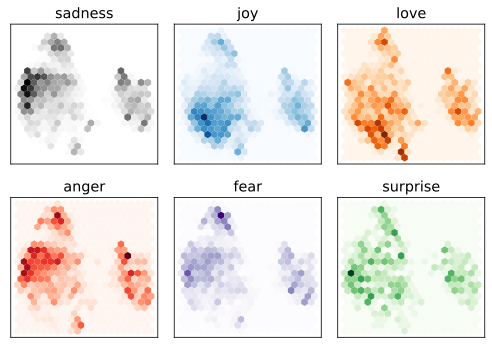

In [76]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    print(df_emb_sub)
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

#### 간단한 분류 모델 훈련하기

In [72]:
# 수렴을 보장하기 위해 `max_iter`를 증가시킵니다.
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [73]:
lr_clf.score(X_valid, y_valid)

0.634

In [74]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

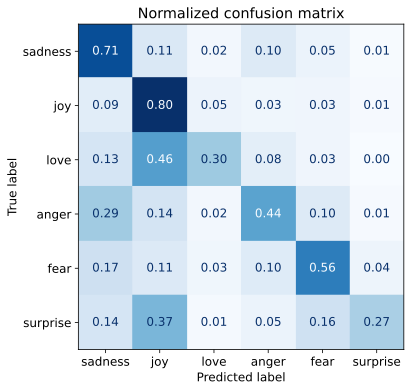

In [77]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

labels = emotions["train"].features["label"].names

# validation 실행 & confusion matrix 시각화    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### 트랜스포머 미세 튜닝하기

<img alt="encoder-tuning" caption="When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-fine-tuning.png?raw=1" id="encoder-tuning"/>

#### 사전 훈련된 모델 로드하기
*   AutoModal 클래스와 달리 **AutoModelForSequenceClassification**은 사전 훈련된 모델 출력 위에 **베이스 모델(basemodel)과 함께 쉽게 훈련할 수 있는 분류 헤드가** 있다는 점이 다르다.

In [78]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

#### 성공 지표 정의하기

In [79]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### 모델 훈련하기


*   데이터셋과 측정 지표가 준비되면 Trainer 클래스를 정의하기 전에 마지막으로 두 가지만 처리하면 된다. 

      1. 허깅페이스 허브에 로그인하고, 미세튜닝한 모델을 허브 계정에 저장하고 커뮤니티에 공유
      2. 훈련을 위한 모든 하이퍼파라미터를 정의





In [80]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [81]:
from transformers import Trainer, TrainingArguments
# 훈련 파라미터를 정의하기 위해 TrainingArguments 클래스를 사용한다. 
# TrainingArguments 클래스는 많은 정보를 저장하며 훈련과 평가를 상세하게 제어한다.

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [82]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/hoonface/distilbert-base-uncased-finetuned-emotion into local empty directory.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.821900,0.309394,0.911000,0.907293
2,0.249600,0.215427,0.924500,0.924527


In [83]:
# Trainer 클래스의 predict() method는 평가에 사용할 수 있는 몇 가지 유용한 객체를 반환한다.
# predict() method의 출력은 Predictionoutput 객체로 predictions, label_ids 배열과 함께 Trainer class에 전달한 측정 지표의 값도 담고 있다.

preds_output = trainer.predict(emotions_encoded["validation"])

In [84]:
preds_output.metrics

{'test_loss': 0.21542678773403168,
 'test_accuracy': 0.9245,
 'test_f1': 0.9245266966207797,
 'test_runtime': 4.0504,
 'test_samples_per_second': 493.784,
 'test_steps_per_second': 7.901}

In [89]:
print(preds_output.predictions.shape)
print(preds_output.predictions)

(2000, 6)
[[ 4.5330243  -0.683376   -0.6646328  -0.99132526 -0.584904   -1.740854  ]
 [ 4.323519   -0.90632516 -1.3242046  -0.7872492  -0.0433572  -1.6443443 ]
 [-1.1291958   2.2250478   3.003084   -1.0246149  -1.5871398  -0.96799695]
 ...
 [-1.0793393   4.691447    0.1926962  -0.9921215  -1.2352594  -0.9646081 ]
 [-1.686465    2.8604257   2.7877774  -1.3057122  -1.5434139  -0.5056707 ]
 [-1.4324746   4.375892    0.28720537 -1.3076471  -1.3178705  -0.14313205]]


In [85]:
y_preds = np.argmax(preds_output.predictions, axis=1)

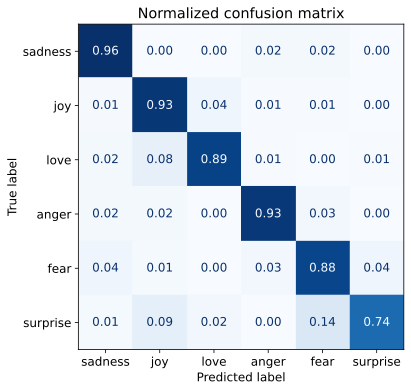

In [87]:
plot_confusion_matrix(y_preds, y_valid, labels)

### 사이드바: 케라스로 미세 튜닝하기

In [ ]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels=num_labels))

In [ ]:
# 텐서플로 텐서로 변환할 열 이름
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

In [ ]:
import tensorflow as tf

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

Epoch 1/2
250/250 [==============================] - 145s 533ms/step - loss: 0.5221 - sparse_categorical_accuracy: 0.8206 - val_loss: 0.1881 - val_sparse_categorical_accuracy: 0.9300
Epoch 2/2
250/250 [==============================] - 132s 526ms/step - loss: 0.1364 - sparse_categorical_accuracy: 0.9418 - val_loss: 0.1308 - val_sparse_categorical_accuracy: 0.9375


### 사이드바 끝

#### 오류 분석

In [92]:
for k, v in batch.items():
  print(k)
  print(v)
# tokenizer.model_input_names

NameError: ignored

In [93]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 모든 입력 텐서를 모델과 같은 장치로 이동합니다.
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # 다른 데이터셋 열과 호환되도록 출력을 CPU로 옮깁니다.
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [94]:
# 데이터셋을 다시 파이토치 텐서로 변환합니다.
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# 손실 값을 계산합니다.
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [101]:
emotions_encoded["validation"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'loss': Value(dtype='float32', id=None),
 'predicted_label': Value(dtype='int64', id=None)}

In [102]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [103]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.301235
1963,i called myself pro life and voted for perry w...,joy,sadness,5.275865
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.220357
1274,i am going to several holiday parties and i ca...,joy,sadness,5.115796
1950,i as representative of everything thats wrong ...,surprise,sadness,5.075392
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.048799
765,i feel super awkward and out of place right now,joy,sadness,4.959546
1509,i guess this is a memoir so it feels like that...,joy,fear,4.841307
465,i would eventually go in to these stores but i...,joy,fear,4.828467
1111,im lazy my characters fall into categories of ...,joy,fear,4.645075


In [104]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
260,i am feeling so invigorated and so ready to ke...,joy,joy,0.018427
1263,i feel this way about blake lively,joy,joy,0.018618
669,i am not feeling very joyful today its been a ...,joy,joy,0.018674
1418,i am a big believer in the phrase that some pe...,joy,joy,0.018803
1873,i feel practically virtuous this month i have ...,joy,joy,0.018906
1012,i definitely succumbed to pre holiday sales bu...,joy,joy,0.018924
199,i feel invigorated full of energy ready for th...,joy,joy,0.018925
1205,i log on feeling vaguely sociable and after a ...,joy,joy,0.018969
4,i can have for a treat or if i am feeling festive,joy,joy,0.019030
1561,i came to tv stations for first debut stage i ...,joy,joy,0.019080


#### 모델 저장 및 공유

In [105]:
trainer.push_to_hub(commit_message="Training completed!")

Upload file runs/Mar06_14-03-46_3cc08e8e3f45/events.out.tfevents.1678111459.3cc08e8e3f45.163.0: 100%|#########…

To https://huggingface.co/hoonface/distilbert-base-uncased-finetuned-emotion
   bd7a431..bc28106  main -> main

   bd7a431..bc28106  main -> main

To https://huggingface.co/hoonface/distilbert-base-uncased-finetuned-emotion
   bc28106..673b7d9  main -> main

   bc28106..673b7d9  main -> main



'https://huggingface.co/hoonface/distilbert-base-uncased-finetuned-emotion/commit/bc281061cc8b85b4d334bd545c930afee7076745'

In [106]:
from transformers import pipeline

# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
model_id = "hoonface/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [107]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [111]:
# label_1 > joy 로 예측한 score가 가장 높은 것을 확인할 수 있다.
preds

[[{'label': 'LABEL_0', 'score': 0.010409238748252392},
  {'label': 'LABEL_1', 'score': 0.9595775604248047},
  {'label': 'LABEL_2', 'score': 0.009237720631062984},
  {'label': 'LABEL_3', 'score': 0.009504783898591995},
  {'label': 'LABEL_4', 'score': 0.005936808418482542},
  {'label': 'LABEL_5', 'score': 0.005333869718015194}]]

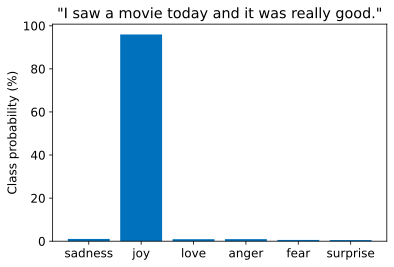

In [112]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

In [113]:
print(preds_df)

     label     score
0  LABEL_0  0.010409
1  LABEL_1  0.959578
2  LABEL_2  0.009238
3  LABEL_3  0.009505
4  LABEL_4  0.005937
5  LABEL_5  0.005334


## 결론